## Load the data


In [58]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [59]:
import pandas as pd

df = pd.read_csv('/content/irrigation.csv')
df.head()

,Time,Soil(%),Temp(C),Humidity(%),Motor,Rain,PIR
0,0:08:27,41,30.6,87.3,Off,No,Found
1,0:08:28,41,30.6,87.1,Off,No,Found
2,0:08:29,41,30.6,87.1,Off,No,Found
3,0:08:30,41,30.6,87.0,Off,No,Found
4,0:08:31,41,30.6,86.8,Off,No,Found


## Explore the data



In [60]:
# Data information
print("Dataset info:")
print(df.info())
print("\nSummary statistics:")
df.describe()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         1400 non-null   object 
 1   Soil(%)      1400 non-null   int64  
 2   Temp(C)      1400 non-null   float64
 3   Humidity(%)  1400 non-null   float64
 4   Motor        1400 non-null   object 
 5   Rain         1400 non-null   object 
 6   PIR          1360 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 76.7+ KB
None

Summary statistics:


,Soil(%),Temp(C),Humidity(%)
count,1400.000000,1400.000000,1400.000000
mean,38.513571,31.200714,84.480643
std,0.983692,0.637879,2.360030
min,37.000000,30.400000,78.100000
25%,38.000000,30.600000,82.600000
50%,38.000000,31.200000,84.700000
75%,39.000000,31.500000,86.700000
max,41.000000,32.800000,87.800000


## Define moisture thresholds




In [61]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
Time            0
Soil(%)         0
Temp(C)         0
Humidity(%)     0
Motor           0
Rain            0
PIR            40
dtype: int64


In [63]:
# Drop the 'Motor', 'Rain', and 'PIR' columns from the DataFrame
# Note: These columns were already excluded from the feature set used for model training
df = df.drop(['Motor', 'Rain', 'PIR'], axis=1)

print("DataFrame after dropping Motor, Rain, and PIR columns:")
display(df.head())

DataFrame after dropping Motor, Rain, and PIR columns:


,Time,Soil(%),Temp(C),Humidity(%)
0,0:08:27,41,30.6,87.3
1,0:08:28,41,30.6,87.1
2,0:08:29,41,30.6,87.1
3,0:08:30,41,30.6,87.0
4,0:08:31,41,30.6,86.8


In [64]:
# Convert Time to datetime and set as index
df['Time'] = pd.to_timedelta(df['Time'])
df.set_index('Time', inplace=True)
print("Time range of data:", df.index.min(), "to", df.index.max())

Time range of data: 0 days 00:08:27 to 0 days 00:31:46


In [65]:
# Define moisture thresholds (adjust these based on your needs)
MIN_MOISTURE = 35  # Minimum acceptable soil moisture level
MAX_MOISTURE = 45  # Target soil moisture level after irrigation

print(f"Minimum moisture threshold: {MIN_MOISTURE}%")
print(f"Maximum moisture threshold: {MAX_MOISTURE}%")

Minimum moisture threshold: 35%
Maximum moisture threshold: 45%


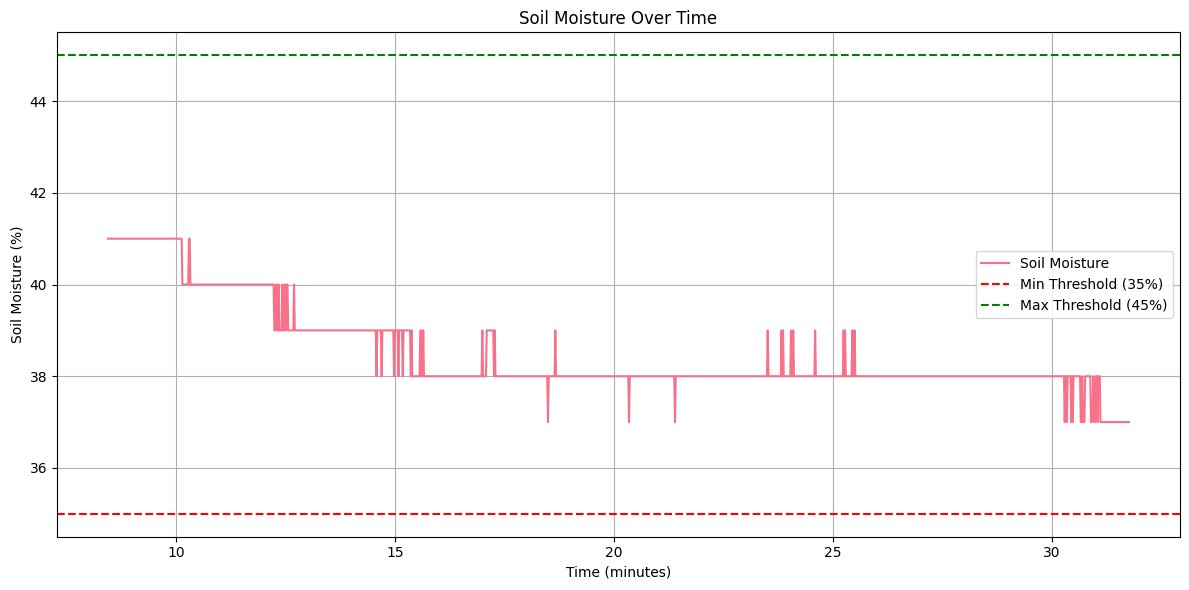

In [66]:
# Visualize the soil moisture over time
plt.figure(figsize=(12, 6))
plt.plot(df.index.total_seconds() / 60, df['Soil(%)'], label='Soil Moisture')
plt.axhline(y=MIN_MOISTURE, color='r', linestyle='--', label=f'Min Threshold ({MIN_MOISTURE}%)')
plt.axhline(y=MAX_MOISTURE, color='g', linestyle='--', label=f'Max Threshold ({MAX_MOISTURE}%)')
plt.xlabel('Time (minutes)')
plt.ylabel('Soil Moisture (%)')
plt.title('Soil Moisture Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

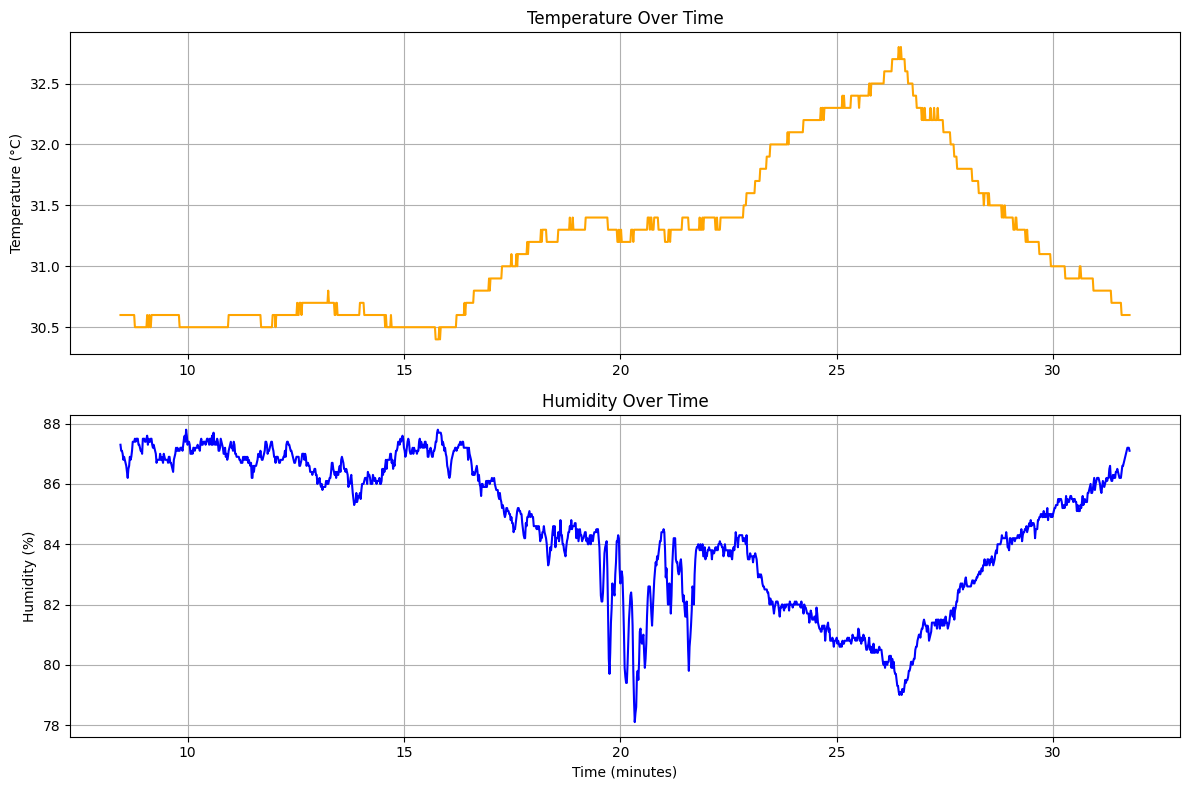

In [67]:
# Visualize temperature and humidity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(df.index.total_seconds() / 60, df['Temp(C)'], color='orange')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Temperature Over Time')
ax1.grid(True)

ax2.plot(df.index.total_seconds() / 60, df['Humidity(%)'], color='blue')
ax2.set_xlabel('Time (minutes)')
ax2.set_ylabel('Humidity (%)')
ax2.set_title('Humidity Over Time')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [68]:
# Calculate rate of moisture change
df['Moisture_Change'] = df['Soil(%)'].diff()
df['Time_Minutes'] = df.index.total_seconds() / 60
df['Time_Diff'] = df['Time_Minutes'].diff()

# Remove first row with NaN values
df_clean = df.dropna().copy()

print("Average moisture change per minute:", df_clean['Moisture_Change'].mean())

Average moisture change per minute: -0.0028591851322373124


In [69]:
# Prepare data for prediction model
# We'll predict moisture change based on temperature and humidity
X = df_clean[['Temp(C)', 'Humidity(%)']]
y = df_clean['Moisture_Change']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 1119
Testing set size: 280


In [70]:
# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate model performance
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print("Linear Regression Model Performance:")
print(f"Mean Absolute Error: {mae_lr:.4f}")
print(f"Mean Squared Error: {mse_lr:.4f}")
print(f"Coefficients: Temp={lr_model.coef_[0]:.4f}, Humidity={lr_model.coef_[1]:.4f}")
print(f"Intercept: {lr_model.intercept_:.4f}")

Linear Regression Model Performance:
Mean Absolute Error: 0.0826
Mean Squared Error: 0.0789
Coefficients: Temp=0.0272, Humidity=0.0067
Intercept: -1.4138


In [71]:
# Train a Random Forest model for comparison
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate model performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Random Forest Model Performance:")
print(f"Mean Absolute Error: {mae_rf:.4f}")
print(f"Mean Squared Error: {mse_rf:.4f}")

Random Forest Model Performance:
Mean Absolute Error: 0.1147
Mean Squared Error: 0.0957


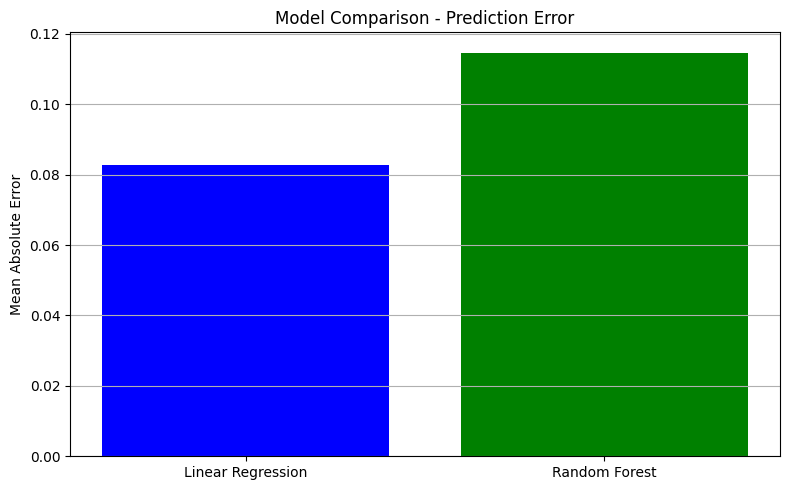

In [72]:
# Compare model performance
models = ['Linear Regression', 'Random Forest']
mae_scores = [mae_lr, mae_rf]

plt.figure(figsize=(8, 5))
plt.bar(models, mae_scores, color=['blue', 'green'])
plt.ylabel('Mean Absolute Error')
plt.title('Model Comparison - Prediction Error')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [77]:
# Import additional libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import requests
import json
from datetime import datetime, timedelta

In [78]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'MLP': MLPRegressor(random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    cv_mae = -cv_scores.mean()

    # Store results
    results[name] = {
        'model': model,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'cv_mae': cv_mae
    }

    print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}, CV MAE={cv_mae:.4f}")

Linear Regression: MAE=0.0826, RMSE=0.2809, CV MAE=0.0650
Decision Tree: MAE=0.1119, RMSE=0.3158, CV MAE=0.1035
Random Forest: MAE=0.1147, RMSE=0.3093, CV MAE=0.1000
Gradient Boosting: MAE=0.1067, RMSE=0.3046, CV MAE=0.0927
XGBoost: MAE=0.1118, RMSE=0.3152, CV MAE=0.1040
MLP: MAE=0.0865, RMSE=0.2808, CV MAE=0.0916


Model Comparison (sorted by MAE):
               Model       MAE      RMSE    CV_MAE
0  Linear Regression  0.082586  0.280868  0.064961
5                MLP  0.086453  0.280770  0.091611
3  Gradient Boosting  0.106716  0.304628  0.092734
4            XGBoost  0.111832  0.315189  0.103987
1      Decision Tree  0.111928  0.315821  0.103466
2      Random Forest  0.114664  0.309274  0.099996


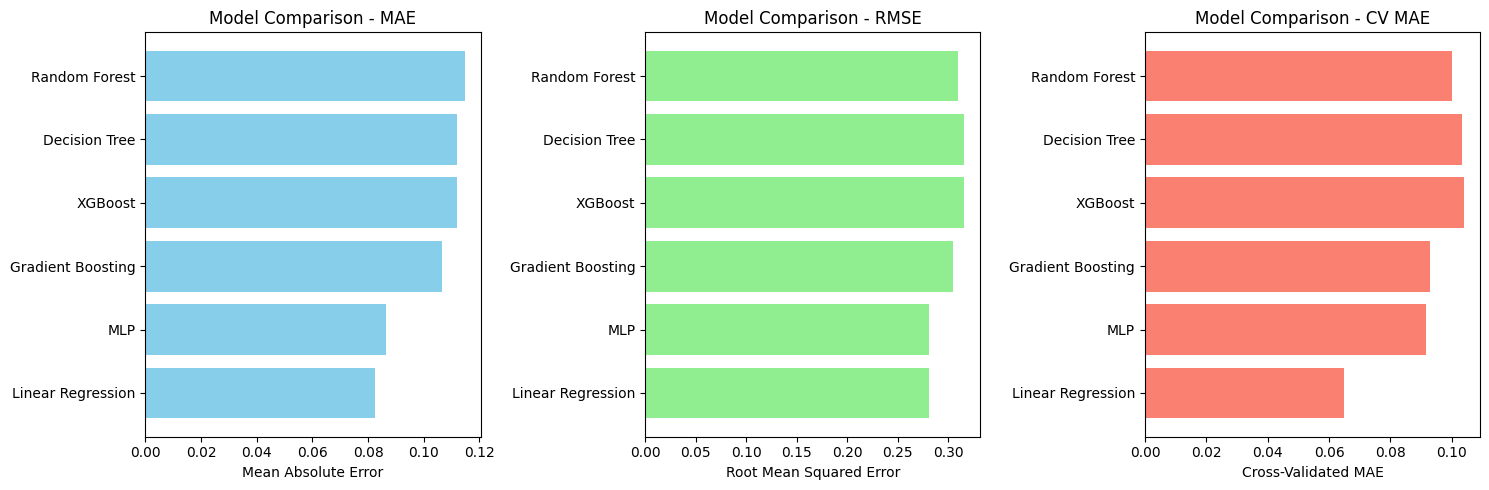

In [79]:
# Compare model performance
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[name]['mae'] for name in results],
    'RMSE': [results[name]['rmse'] for name in results],
    'CV_MAE': [results[name]['cv_mae'] for name in results]
}).sort_values('MAE')

print("Model Comparison (sorted by MAE):")
print(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE comparison
axes[0].barh(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
axes[0].set_xlabel('Mean Absolute Error')
axes[0].set_title('Model Comparison - MAE')

# RMSE comparison
axes[1].barh(comparison_df['Model'], comparison_df['RMSE'], color='lightgreen')
axes[1].set_xlabel('Root Mean Squared Error')
axes[1].set_title('Model Comparison - RMSE')

# Cross-validated MAE comparison
axes[2].barh(comparison_df['Model'], comparison_df['CV_MAE'], color='salmon')
axes[2].set_xlabel('Cross-Validated MAE')
axes[2].set_title('Model Comparison - CV MAE')

plt.tight_layout()
plt.show()

In [80]:
# Select the best model based on MAE
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"Best model: {best_model_name} with MAE: {results[best_model_name]['mae']:.4f}")

Best model: Linear Regression with MAE: 0.0826


In [81]:
# Weather API integration function
def get_weather_forecast(api_key, lat, lon, hours=24):
    """
    Get weather forecast from OpenWeatherMap API
    """
    url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}&units=metric"

    try:
        response = requests.get(url)
        data = response.json()

        if response.status_code == 200:
            # Extract relevant forecast data
            forecast = []
            for item in data['list']:
                if len(forecast) >= hours/3:  # API provides data every 3 hours
                    break

                forecast.append({
                    'datetime': datetime.fromtimestamp(item['dt']),
                    'temp': item['main']['temp'],
                    'humidity': item['main']['humidity'],
                    'rain': item.get('rain', {}).get('3h', 0),  # Rain in last 3 hours
                    'description': item['weather'][0]['description']
                })

            return forecast
        else:
            print(f"Error: {data['message']}")
            return None

    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return None

# Example usage (you'll need to replace with your actual API key and coordinates)
# api_key = "your_openweathermap_api_key"
# lat = 37.7749  # Example coordinates (San Francisco)
# lon = -122.4194
# forecast = get_weather_forecast(api_key, lat, lon)

In [82]:
# Mock weather data for demonstration (since we don't have a real API key)
def get_mock_weather_forecast():
    """
    Generate mock weather data for demonstration
    """
    now = datetime.now()
    forecast = []

    for i in range(8):  # 24 hours in 3-hour increments
        forecast_time = now + timedelta(hours=i*3)

        # Vary temperature and humidity realistically
        temp = 25 + 5 * np.sin(i * np.pi / 4)  # Simulate diurnal cycle
        humidity = 60 + 20 * np.cos(i * np.pi / 4)  # Inverse relationship with temp

        # Random chance of rain (higher in the afternoon)
        rain_chance = 0.1 if i < 2 or i > 6 else 0.3  # Higher chance in afternoon
        will_rain = np.random.random() < rain_chance
        rain_amount = np.random.exponential(0.5) if will_rain else 0

        forecast.append({
            'datetime': forecast_time,
            'temp': max(15, min(35, temp)),  # Keep in reasonable range
            'humidity': max(40, min(90, humidity)),
            'rain': rain_amount,
            'description': 'Rain' if will_rain else 'Clear'
        })

    return forecast

# Get mock forecast
forecast = get_mock_weather_forecast()
print("Weather Forecast for next 24 hours:")
for f in forecast:
    print(f"{f['datetime'].strftime('%H:%M')}: {f['temp']:.1f}°C, {f['humidity']}% humidity, "
          f"rain: {f['rain']:.1f}mm, {f['description']}")

Weather Forecast for next 24 hours:
20:14: 25.0°C, 80.0% humidity, rain: 0.7mm, Rain
23:14: 28.5°C, 74.14213562373095% humidity, rain: 0.0mm, Clear
02:14: 30.0°C, 60.0% humidity, rain: 0.0mm, Clear
05:14: 28.5°C, 45.85786437626905% humidity, rain: 0.0mm, Clear
08:14: 25.0°C, 40% humidity, rain: 0.0mm, Clear
11:14: 21.5°C, 45.85786437626905% humidity, rain: 0.0mm, Clear
14:14: 20.0°C, 59.99999999999999% humidity, rain: 0.0mm, Clear
17:14: 21.5°C, 74.14213562373095% humidity, rain: 0.0mm, Clear


In [83]:
# Mock weather data for demonstration (since we don't have a real API key)
def get_mock_weather_forecast():
    """
    Generate mock weather data for demonstration
    """
    now = datetime.now()
    forecast = []

    for i in range(8):  # 24 hours in 3-hour increments
        forecast_time = now + timedelta(hours=i*3)

        # Vary temperature and humidity realistically
        temp = 25 + 5 * np.sin(i * np.pi / 4)  # Simulate diurnal cycle
        humidity = 60 + 20 * np.cos(i * np.pi / 4)  # Inverse relationship with temp

        # Random chance of rain (higher in the afternoon)
        rain_chance = 0.1 if i < 2 or i > 6 else 0.3  # Higher chance in afternoon
        will_rain = np.random.random() < rain_chance
        rain_amount = np.random.exponential(0.5) if will_rain else 0

        forecast.append({
            'datetime': forecast_time,
            'temp': max(15, min(35, temp)),  # Keep in reasonable range
            'humidity': max(40, min(90, humidity)),
            'rain': rain_amount,
            'description': 'Rain' if will_rain else 'Clear'
        })

    return forecast

# Get mock forecast
forecast = get_mock_weather_forecast()
print("Weather Forecast for next 24 hours:")
for f in forecast:
    print(f"{f['datetime'].strftime('%H:%M')}: {f['temp']:.1f}°C, {f['humidity']}% humidity, "
          f"rain: {f['rain']:.1f}mm, {f['description']}")

Weather Forecast for next 24 hours:
20:14: 25.0°C, 80.0% humidity, rain: 0.0mm, Clear
23:14: 28.5°C, 74.14213562373095% humidity, rain: 0.0mm, Clear
02:14: 30.0°C, 60.0% humidity, rain: 0.0mm, Clear
05:14: 28.5°C, 45.85786437626905% humidity, rain: 0.0mm, Clear
08:14: 25.0°C, 40% humidity, rain: 0.0mm, Clear
11:14: 21.5°C, 45.85786437626905% humidity, rain: 0.0mm, Clear
14:14: 20.0°C, 59.99999999999999% humidity, rain: 0.2mm, Rain
17:14: 21.5°C, 74.14213562373095% humidity, rain: 0.3mm, Rain


In [84]:
# Enhanced irrigation predictor with weather integration
def enhanced_irrigation_predictor(current_moisture, current_temp, current_humidity,
                                 model=best_model, min_moisture=MIN_MOISTURE,
                                 max_moisture=MAX_MOISTURE, forecast_data=None):
    """
    Enhanced irrigation predictor that considers weather forecast
    """
    # Check if irrigation is needed now
    if current_moisture <= min_moisture:
        # Check if rain is coming soon that might make irrigation unnecessary
        rain_soon = False
        if forecast_data:
            # Check if significant rain is expected in the next 6 hours
            for i, forecast in enumerate(forecast_data[:2]):  # Next 6 hours (2 periods of 3 hours)
                if forecast['rain'] > 1.0:  # More than 1mm of rain
                    rain_soon = True
                    rain_time = forecast['datetime']
                    break

        if rain_soon:
            return {
                "irrigation_needed": False,
                "message": f"Moisture low but rain expected at {rain_time.strftime('%H:%M')}. Irrigation not needed.",
                "current_moisture": current_moisture,
                "time_until_irrigation": None,
                "rain_expected": True
            }
        else:
            return {
                "irrigation_needed": True,
                "message": "Irrigation needed immediately",
                "current_moisture": current_moisture,
                "time_until_irrigation": 0,
                "rain_expected": False
            }

    # Predict when irrigation will be needed under current conditions
    time_until = predict_irrigation_time(model, current_moisture, current_temp, current_humidity, min_moisture)

    if time_until == float('inf'):
        return {
            "irrigation_needed": False,
            "message": "No irrigation needed - moisture is stable or increasing",
            "current_moisture": current_moisture,
            "time_until_irrigation": None,
            "rain_expected": False
        }

    # Check if rain is expected before irrigation would be needed
    rain_before_irrigation = False
    if forecast_data:
        # Find the first forecast period with significant rain
        for forecast in forecast_data:
            hours_until_rain = (forecast['datetime'] - datetime.now()).total_seconds() / 3600
            if hours_until_rain > 0 and forecast['rain'] > 1.0 and hours_until_rain < time_until/60:
                rain_before_irrigation = True
                break

    if rain_before_irrigation:
        return {
            "irrigation_needed": False,
            "message": f"Rain expected before irrigation would be needed. No irrigation necessary.",
            "current_moisture": current_moisture,
            "time_until_irrigation": None,
            "rain_expected": True
        }
    else:
        return {
            "irrigation_needed": False,
            "message": f"Irrigation needed in {time_until:.1f} minutes",
            "current_moisture": current_moisture,
            "time_until_irrigation": time_until,
            "rain_expected": False
        }

# Predict irrigation function
def predict_irrigation_time(model, current_moisture, current_temp, current_humidity, threshold=MIN_MOISTURE):
    """
    Predict how long until soil moisture reaches the threshold
    """
    # Predict moisture change rate
    moisture_change = model.predict([[current_temp, current_humidity]])[0]

    # Calculate time until threshold is reached (in minutes)
    if moisture_change >= 0:
        return float('inf')  # Moisture is increasing, no need for irrigation

    time_to_threshold = (current_moisture - threshold) / abs(moisture_change)
    return time_to_threshold

In [86]:
from datetime import datetime

# Enhanced irrigation predictor with weather integration
def enhanced_irrigation_predictor(current_moisture, current_temp, current_humidity,
                                 model, min_moisture, max_moisture, forecast_data=None):
    """
    Enhanced irrigation predictor that considers weather forecast.
    Results are displayed in hours and minutes instead of raw minutes.
    """
    # Check if irrigation is needed now
    if current_moisture <= min_moisture:
        # Check if rain is coming soon that might make irrigation unnecessary
        rain_soon = False
        rain_time = None
        if forecast_data:
            # Check if significant rain is expected in the next 6 hours
            for forecast in forecast_data[:2]:  # Next 6 hours (2 periods of 3 hours)
                if forecast['rain'] > 1.0:  # More than 1mm of rain
                    rain_soon = True
                    rain_time = forecast['datetime']
                    break

        if rain_soon:
            return {
                "irrigation_needed": False,
                "message": f"Moisture low but rain expected at {rain_time.strftime('%H:%M')}. Irrigation not needed.",
                "current_moisture": current_moisture,
                "time_until_irrigation": None,
                "rain_expected": True
            }
        else:
            return {
                "irrigation_needed": True,
                "message": "Irrigation needed immediately",
                "current_moisture": current_moisture,
                "time_until_irrigation": 0,
                "rain_expected": False
            }

    # Predict when irrigation will be needed under current conditions
    time_until_minutes = predict_irrigation_time(model, current_moisture, current_temp, current_humidity, min_moisture)

    if time_until_minutes == float('inf'):
        return {
            "irrigation_needed": False,
            "message": "No irrigation needed - moisture is stable or increasing",
            "current_moisture": current_moisture,
            "time_until_irrigation": None,
            "rain_expected": False
        }

    # Convert to hours and minutes for nicer output
    hours = int(time_until_minutes // 60)
    minutes = int(time_until_minutes % 60)
    time_str = f"{hours}h {minutes}m" if hours > 0 else f"{minutes}m"

    # Check if rain is expected before irrigation would be needed
    rain_before_irrigation = False
    if forecast_data:
        for forecast in forecast_data:
            hours_until_rain = (forecast['datetime'] - datetime.now()).total_seconds() / 3600
            if hours_until_rain > 0 and forecast['rain'] > 1.0 and hours_until_rain < time_until_minutes/60:
                rain_before_irrigation = True
                break

    if rain_before_irrigation:
        return {
            "irrigation_needed": False,
            "message": f"Rain expected before irrigation would be needed. No irrigation necessary.",
            "current_moisture": current_moisture,
            "time_until_irrigation": None,
            "rain_expected": True
        }
    else:
        return {
            "irrigation_needed": False,
            "message": f"Irrigation needed in {time_str}",
            "current_moisture": current_moisture,
            "time_until_irrigation": time_until_minutes,
            "rain_expected": False
        }


# Predict irrigation function
def predict_irrigation_time(model, current_moisture, current_temp, current_humidity, threshold):
    """
    Predict how long until soil moisture reaches the threshold.
    Returns time in minutes.
    """
    # Predict moisture change rate per minute
    moisture_change = model.predict([[current_temp, current_humidity]])[0]

    # Calculate time until threshold is reached (in minutes)
    if moisture_change >= 0:
        return float('inf')  # Moisture is increasing, no need for irrigation

    time_to_threshold = (current_moisture - threshold) / abs(moisture_change)
    return time_to_threshold


In [88]:
# Get current conditions
current_moisture = df['Soil(%)'].iloc[-1]
current_temp = df['Temp(C)'].iloc[-1]
current_humidity = df['Humidity(%)'].iloc[-1]

print("Current conditions:")
print(f"Soil Moisture: {current_moisture:.1f}%")
print(f"Temperature: {current_temp:.1f}°C")
print(f"Humidity: {current_humidity:.1f}%")

# Get weather forecast
forecast = get_mock_weather_forecast()

# Make prediction with enhanced function
result = enhanced_irrigation_predictor(
    current_moisture, current_temp, current_humidity,
    best_model, MIN_MOISTURE, MAX_MOISTURE, forecast
)

print("\nEnhanced Irrigation Prediction Result:")
print(f"Message: {result['message']}")
print(f"Current Moisture: {result['current_moisture']:.1f}%")

if result['time_until_irrigation'] is not None:
    hours = int(result['time_until_irrigation'] // 60)
    minutes = int(result['time_until_irrigation'] % 60)
    if hours > 0:
        print(f"Time until irrigation: {hours}h {minutes}m")
    else:
        print(f"Time until irrigation: {minutes}m")
else:
    print("Time until irrigation: N/A")

print(f"Rain expected: {'Yes' if result['rain_expected'] else 'No'}")
print(f"Irrigation needed now: {'Yes' if result['irrigation_needed'] else 'No'}")


Current conditions:
Soil Moisture: 37.0%
Temperature: 30.6°C
Humidity: 87.1%

Enhanced Irrigation Prediction Result:
Message: Irrigation needed in 55h 46m
Current Moisture: 37.0%
Time until irrigation: 55h 46m
Rain expected: No
Irrigation needed now: No


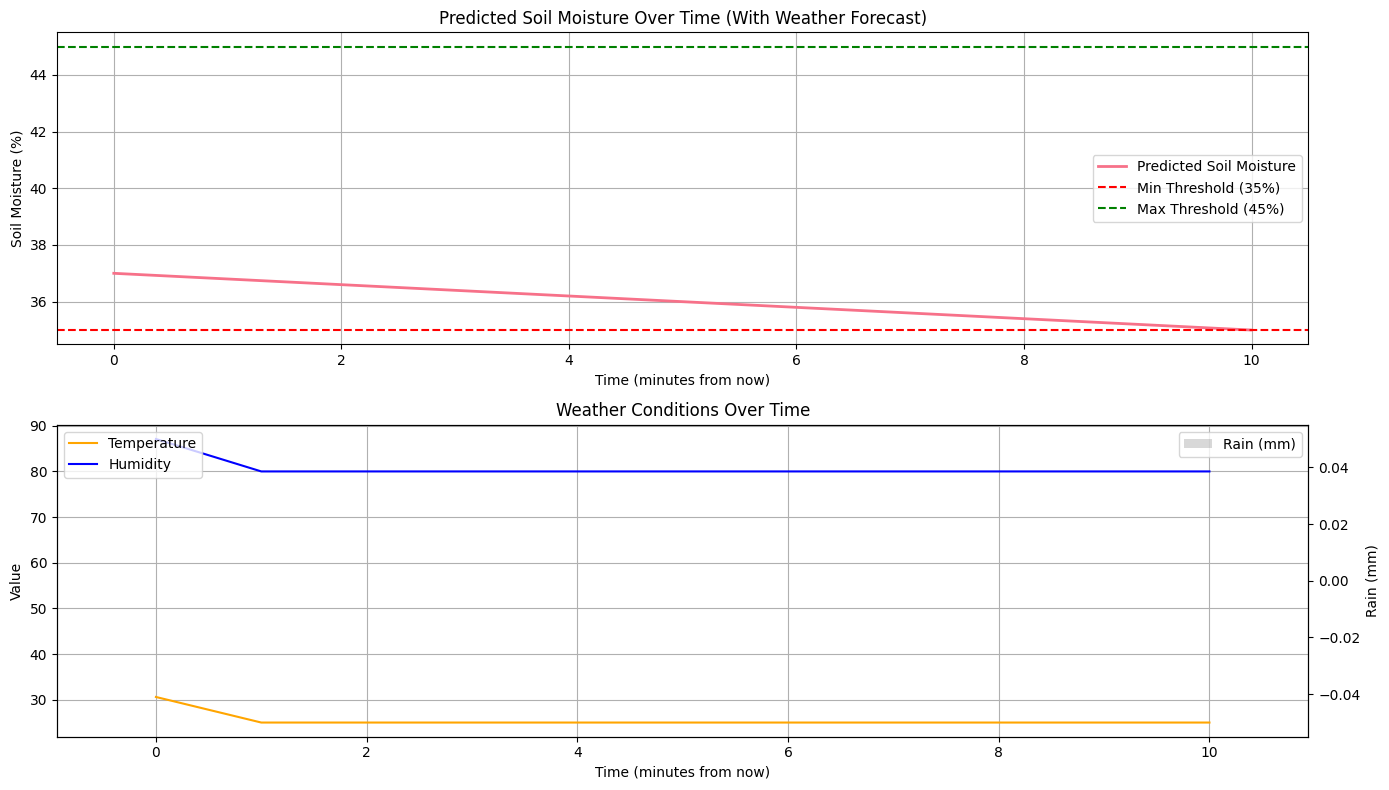

In [89]:
# Simulate future moisture with weather consideration
def simulate_future_moisture_with_weather(model, current_moisture, current_temp, current_humidity,
                                         forecast_data, steps=120):
    """
    Simulate future moisture levels considering weather forecast
    """
    moisture_levels = [current_moisture]
    times = [0]  # Start at time 0 (current)
    weather_conditions = [{"temp": current_temp, "humidity": current_humidity, "rain": 0}]

    now = datetime.now()

    for i in range(1, steps + 1):
        # Calculate current time for this step
        current_time = now + timedelta(minutes=i)

        # Find appropriate forecast data
        forecast_temp, forecast_humidity, forecast_rain = current_temp, current_humidity, 0

        # Find the closest forecast period
        for forecast in forecast_data:
            time_diff = (forecast['datetime'] - current_time).total_seconds()
            if abs(time_diff) < 90 * 60:  # Within 1.5 hours
                forecast_temp = forecast['temp']
                forecast_humidity = forecast['humidity']
                forecast_rain = forecast['rain']
                break

        # Predict moisture change
        moisture_change = model.predict([[forecast_temp, forecast_humidity]])[0]

        # Adjust for rain (rain increases moisture)
        if forecast_rain > 0:
            # Estimate moisture increase from rain (simplified model)
            rain_effect = forecast_rain * 0.5  # 0.5% moisture increase per mm of rain
            moisture_change += rain_effect

        # Update moisture level
        new_moisture = moisture_levels[-1] + moisture_change
        moisture_levels.append(new_moisture)
        times.append(i)
        weather_conditions.append({
            "temp": forecast_temp,
            "humidity": forecast_humidity,
            "rain": forecast_rain
        })

        # Stop if we reach the threshold
        if new_moisture <= MIN_MOISTURE:
            break

    return times, moisture_levels, weather_conditions

# Simulate future moisture with weather
times, moisture_levels, weather_conditions = simulate_future_moisture_with_weather(
    best_model, current_moisture, current_temp, current_humidity, forecast, 180
)

# Plot the simulation
plt.figure(figsize=(14, 8))

# Moisture plot
plt.subplot(2, 1, 1)
plt.plot(times, moisture_levels, label='Predicted Soil Moisture', linewidth=2)
plt.axhline(y=MIN_MOISTURE, color='r', linestyle='--', label=f'Min Threshold ({MIN_MOISTURE}%)')
plt.axhline(y=MAX_MOISTURE, color='g', linestyle='--', label=f'Max Threshold ({MAX_MOISTURE}%)')
plt.xlabel('Time (minutes from now)')
plt.ylabel('Soil Moisture (%)')
plt.title('Predicted Soil Moisture Over Time (With Weather Forecast)')
plt.legend()
plt.grid(True)

# Weather conditions plot
plt.subplot(2, 1, 2)
temps = [w['temp'] for w in weather_conditions]
humidity = [w['humidity'] for w in weather_conditions]
rain = [w['rain'] for w in weather_conditions]

plt.plot(times, temps, label='Temperature', color='orange')
plt.plot(times, humidity, label='Humidity', color='blue')
plt.xlabel('Time (minutes from now)')
plt.ylabel('Value')
plt.title('Weather Conditions Over Time')
plt.legend(loc='upper left')
plt.grid(True)

# Add rain bars
ax2 = plt.gca().twinx()
ax2.bar(times, rain, alpha=0.3, color='gray', label='Rain (mm)')
ax2.set_ylabel('Rain (mm)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [90]:
# Test with different scenarios and weather conditions
test_scenarios = [
    (37, 30, 85),  # Close to threshold
    (41, 30, 85),  # Current conditions
    (45, 35, 70),  # Higher temp, lower humidity (faster drying)
    (42, 25, 90),  # Lower temp, higher humidity (slower drying)
]

print("Testing different scenarios with weather forecast:")
print("=" * 70)
for i, (moisture, temp, humidity) in enumerate(test_scenarios, 1):
    result = enhanced_irrigation_predictor(moisture, temp, humidity, best_model,
                                         MIN_MOISTURE, MAX_MOISTURE, forecast)
    print(f"Scenario {i}: {moisture}% moisture, {temp}°C, {humidity}% humidity")
    print(f"Result: {result['message']}")
    if result['rain_expected']:
        print("Note: Rain is expected in the forecast")
    print("-" * 50)

Testing different scenarios with weather forecast:
Scenario 1: 37% moisture, 30°C, 85% humidity
Result: Irrigation needed in 1h 4m
--------------------------------------------------
Scenario 2: 41% moisture, 30°C, 85% humidity
Result: Irrigation needed in 3h 13m
--------------------------------------------------
Scenario 3: 45% moisture, 35°C, 70% humidity
Result: No irrigation needed - moisture is stable or increasing
--------------------------------------------------
Scenario 4: 42% moisture, 25°C, 90% humidity
Result: Irrigation needed in 52m
--------------------------------------------------


In [92]:
from datetime import datetime

# Final irrigation system function for IoT deployment
def smart_irrigation_system(soil_moisture, temperature, humidity,
                           model=best_model, min_moisture=MIN_MOISTURE,
                           max_moisture=MAX_MOISTURE, use_weather=True):
    """
    Complete smart irrigation system for IoT deployment.
    Now explicitly includes hours/minutes in the output dictionary.
    """
    # Get weather forecast if enabled
    forecast_data = None
    if use_weather:
        # In a real implementation, you would use actual API credentials
        # forecast_data = get_weather_forecast(api_key, lat, lon)
        forecast_data = get_mock_weather_forecast()  # Using mock for demo

    # Make prediction
    if use_weather and forecast_data:
        result = enhanced_irrigation_predictor(
            soil_moisture, temperature, humidity, model,
            min_moisture, max_moisture, forecast_data
        )
    else:
        result = irrigation_predictor(
            soil_moisture, temperature, humidity, model,
            min_moisture, max_moisture
        )

    # Add hours/minutes breakdown if applicable
    if result.get('time_until_irrigation') not in (None, float('inf')):
        minutes = int(result['time_until_irrigation'])
        hours = minutes // 60
        mins = minutes % 60
        result['time_until_irrigation_hm'] = {
            "hours": hours,
            "minutes": mins,
            "formatted": f"{hours}h {mins}m" if hours > 0 else f"{mins}m"
        }
    else:
        result['time_until_irrigation_hm'] = None

    # Add additional info for IoT system
    result['timestamp'] = datetime.now().isoformat()
    result['model_used'] = best_model_name
    result['weather_integration'] = use_weather

    return result

# Test the complete system
print("Complete Smart Irrigation System Test:")
print("=" * 50)
result = smart_irrigation_system(current_moisture, current_temp, current_humidity, use_weather=True)
for key, value in result.items():
    print(f"{key}: {value}")


Complete Smart Irrigation System Test:
irrigation_needed: False
message: Irrigation needed in 55h 46m
current_moisture: 37
time_until_irrigation: 3346.23175201843
rain_expected: False
time_until_irrigation_hm: {'hours': 55, 'minutes': 46, 'formatted': '55h 46m'}
timestamp: 2025-08-26T20:21:45.227008
model_used: Linear Regression
weather_integration: True


In [93]:
# Import additional libraries for model saving
import joblib
import pickle

In [94]:
# Save the best model using joblib (efficient for scikit-learn models)
joblib.dump(best_model, 'irrigation_model.joblib')
print("Model saved as 'irrigation_model.joblib'")

# Also save using pickle for compatibility
with open('irrigation_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Model saved as 'irrigation_model.pkl'")

# Save the model metadata
model_metadata = {
    'model_name': best_model_name,
    'min_moisture': MIN_MOISTURE,
    'max_moisture': MAX_MOISTURE,
    'training_date': datetime.now().isoformat(),
    'features': ['Temp(C)', 'Humidity(%)'],
    'target': 'Moisture_Change'
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
print("Model metadata saved as 'model_metadata.json'")

Model saved as 'irrigation_model.joblib'
Model saved as 'irrigation_model.pkl'
Model metadata saved as 'model_metadata.json'


In [95]:
# Create a configuration file for the IoT device
config = {
    'model_path': 'irrigation_model.joblib',
    'min_moisture': MIN_MOISTURE,
    'max_moisture': MAX_MOISTURE,
    'sensor_read_interval': 5,  # minutes
    'prediction_horizon': 24,   # hours
    'weather_check_interval': 60,  # minutes
    'api_keys': {
        'openweathermap': 'YOUR_API_KEY_HERE'  # To be filled by user
    },
    'location': {
        'latitude': 0.0,  # To be filled by user
        'longitude': 0.0  # To be filled by user
    }
}

with open('iot_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("IoT configuration saved as 'iot_config.json'")

IoT configuration saved as 'iot_config.json'


In [96]:
# Create a lightweight version of the prediction function for IoT devices
def create_iot_prediction_script():
    script = """
# IoT Irrigation Prediction Script
import joblib
import numpy as np

# Load the trained model
try:
    model = joblib.load('irrigation_model.joblib')
except:
    print("Error: Could not load model")
    exit(1)

def predict_irrigation_time(current_moisture, current_temp, current_humidity, min_moisture=35):
    \"\"\"
    Predict how long until soil moisture reaches the threshold
    \"\"\"
    # Predict moisture change rate
    moisture_change = model.predict([[current_temp, current_humidity]])[0]

    # Calculate time until threshold is reached (in minutes)
    if moisture_change >= 0:
        return float('inf')  # Moisture is increasing, no need for irrigation

    time_to_threshold = (current_moisture - min_moisture) / abs(moisture_change)
    return time_to_threshold

# Example usage (to be replaced with actual sensor readings)
if __name__ == "__main__":
    # Read from sensors (placeholder code)
    current_moisture = 40.5  # Replace with actual sensor reading
    current_temp = 30.2      # Replace with actual sensor reading
    current_humidity = 85.3  # Replace with actual sensor reading

    # Make prediction
    time_until = predict_irrigation_time(current_moisture, current_temp, current_humidity)

    if time_until == float('inf'):
        print("No irrigation needed")
    else:
        print(f"Irrigation needed in {time_until:.1f} minutes")
"""

    with open('iot_irrigation.py', 'w') as f:
        f.write(script)
    print("IoT prediction script saved as 'iot_irrigation.py'")

create_iot_prediction_script()

IoT prediction script saved as 'iot_irrigation.py'


In [97]:
# Create a web API version using Flask
def create_flask_api():
    api_code = """
# Flask API for Irrigation Prediction
from flask import Flask, request, jsonify
import joblib
import numpy as np
from datetime import datetime

app = Flask(__name__)

# Load the trained model
try:
    model = joblib.load('irrigation_model.joblib')
    print("Model loaded successfully")
except:
    print("Error: Could not load model")
    exit(1)

@app.route('/predict', methods=['POST'])
def predict():
    \"\"\"
    API endpoint for irrigation prediction
    Expected JSON payload:
    {
        "moisture": 40.5,
        "temperature": 30.2,
        "humidity": 85.3,
        "min_moisture": 35  (optional)
    }
    \"\"\"
    try:
        data = request.get_json()

        # Extract parameters
        moisture = float(data['moisture'])
        temperature = float(data['temperature'])
        humidity = float(data['humidity'])
        min_moisture = float(data.get('min_moisture', 35))

        # Predict moisture change rate
        moisture_change = model.predict([[temperature, humidity]])[0]

        # Calculate time until threshold is reached
        if moisture_change >= 0:
            time_until = float('inf')
        else:
            time_until = (moisture - min_moisture) / abs(moisture_change)

        # Prepare response
        response = {
            'timestamp': datetime.now().isoformat(),
            'current_moisture': moisture,
            'current_temperature': temperature,
            'current_humidity': humidity,
            'predicted_moisture_change': float(moisture_change),
            'time_until_irrigation_minutes': float(time_until) if time_until != float('inf') else None,
            'irrigation_needed': time_until <= 0 if time_until != float('inf') else False,
            'message': 'Irrigation needed now' if time_until <= 0 else
                      f'Irrigation needed in {time_until:.1f} minutes' if time_until != float('inf') else
                      'No irrigation needed - moisture is stable or increasing'
        }

        return jsonify(response)

    except Exception as e:
        return jsonify({'error': str(e)}), 400

@app.route('/health', methods=['GET'])
def health():
    \"\"\"Health check endpoint\"\"\"
    return jsonify({'status': 'healthy', 'timestamp': datetime.now().isoformat()})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)
"""

    with open('app.py', 'w') as f:
        f.write(api_code)
    print("Flask API saved as 'app.py'")

create_flask_api()

Flask API saved as 'app.py'


In [98]:
# Create requirements files
def create_requirements_files():
    # For the web API
    web_requirements = """
flask==2.3.3
numpy==1.24.3
scikit-learn==1.3.0
joblib==1.3.2
gunicorn==21.2.0
"""

    with open('requirements.txt', 'w') as f:
        f.write(web_requirements)
    print("Web requirements saved as 'requirements.txt'")

    # For IoT devices (minimal)
    iot_requirements = """
numpy==1.24.3
scikit-learn==1.3.0
joblib==1.3.2
"""

    with open('requirements_iot.txt', 'w') as f:
        f.write(iot_requirements)
    print("IoT requirements saved as 'requirements_iot.txt'")

create_requirements_files()

Web requirements saved as 'requirements.txt'
IoT requirements saved as 'requirements_iot.txt'


In [99]:
# Create a Dockerfile for container deployment
def create_dockerfile():
    dockerfile = """
# Use an official Python runtime as a base image
FROM python:3.9-slim

# Set the working directory in the container
WORKDIR /app

# Copy the current directory contents into the container at /app
COPY . /app

# Install any needed packages specified in requirements.txt
RUN pip install --no-cache-dir -r requirements.txt

# Make port 5000 available to the world outside this container
EXPOSE 5000

# Define environment variable
ENV FLASK_APP=app.py

# Run app.py when the container launches
CMD ["flask", "run", "--host=0.0.0.0", "--port=5000"]
"""

    with open('Dockerfile', 'w') as f:
        f.write(dockerfile)
    print("Dockerfile saved as 'Dockerfile'")

create_dockerfile()

Dockerfile saved as 'Dockerfile'


In [100]:
# Create a test script to verify the saved model works correctly
def create_test_script():
    test_script = """
# Test script for the saved irrigation model
import joblib
import numpy as np
import json

def test_model():
    \"\"\"Test the saved model with sample data\"\"\"
    try:
        # Load the model
        model = joblib.load('irrigation_model.joblib')
        print("✓ Model loaded successfully")

        # Load metadata
        with open('model_metadata.json', 'r') as f:
            metadata = json.load(f)
        print(f"✓ Model metadata loaded: {metadata['model_name']}")

        # Test with sample data
        test_data = [
            [30.0, 85.0],  # Similar to training data
            [35.0, 60.0],  # Higher temp, lower humidity
            [25.0, 90.0],  # Lower temp, higher humidity
        ]

        print("\\nTesting model predictions:")
        for i, (temp, humidity) in enumerate(test_data):
            prediction = model.predict([[temp, humidity]])[0]
            print(f"  Test {i+1}: Temp={temp}°C, Humidity={humidity}% → Moisture Change={prediction:.4f}")

        # Test the prediction function
        print("\\nTesting irrigation time prediction:")
        time_until = predict_irrigation_time(model, 40.0, 30.0, 85.0)
        if time_until == float('inf'):
            print("  ✓ No irrigation needed (moisture increasing)")
        else:
            print(f"  ✓ Irrigation needed in {time_until:.1f} minutes")

        print("\\n✓ All tests passed! Model is ready for deployment.")
        return True

    except Exception as e:
        print(f"✗ Error: {e}")
        return False

def predict_irrigation_time(model, current_moisture, current_temp, current_humidity, min_moisture=35):
    \"\"\"
    Predict how long until soil moisture reaches the threshold
    \"\"\"
    # Predict moisture change rate
    moisture_change = model.predict([[current_temp, current_humidity]])[0]

    # Calculate time until threshold is reached (in minutes)
    if moisture_change >= 0:
        return float('inf')  # Moisture is increasing, no need for irrigation

    time_to_threshold = (current_moisture - min_moisture) / abs(moisture_change)
    return time_to_threshold

if __name__ == "__main__":
    test_model()
"""

    with open('test_model.py', 'w') as f:
        f.write(test_script)
    print("Test script saved as 'test_model.py'")

create_test_script()

Test script saved as 'test_model.py'


In [101]:
# Run the test to verify everything works
!python test_model.py

✓ Model loaded successfully
✓ Model metadata loaded: Linear Regression

Testing model predictions:
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
  Test 1: Temp=30.0°C, Humidity=85.0% → Moisture Change=-0.0309
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
  Test 2: Temp=35.0°C, Humidity=60.0% → Moisture Change=-0.0623
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
  Test 3: Temp=25.0°C, Humidity=90.0% → Moisture Change=-0.1333

Testing irrigation time prediction:
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does no